In [1]:
# Import required modules
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import backend as K
from keras.layers import LSTM
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from generator import Generator
from models import *
import h5py
import numpy as np
import sys
import os

# Set Tensorflow backend to avoid full GPU pre-loading
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config = config))

Using TensorFlow backend.


In [2]:
print "Loading Generator"
gen = Generator(dataset_directory = '/scratch/jyotish/show_and_tell_coco/data', cnn_model = 'inception')

Loading Generator


In [12]:
print "Generating model"
model = captioning_model(
            gen.img_feature_size,
            gen.embedding_size,
            gen.max_token_len,
            gen.vocab_size)

Generating model


In [13]:
model.compile('adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Load previously saved model if necessary
from keras.models import load_model

model = load_model('/scratch/jyotish/show_and_tell_coco/data/COCO/models/initial_attend_epoch_5.h5')

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
flatten_cnn_input (InputLayer)  (None, 8, 8, 2048)   0                                            
__________________________________________________________________________________________________
flatten_cnn (Reshape)           (None, 64, 2048)     0           flatten_cnn_input[0][0]          
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 2048)     8192        flatten_cnn[0][0]                
__________________________________________________________________________________________________
cnn_avg (GlobalAveragePooling1D (None, 2048)         0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
word_embed

In [14]:
batch_size = gen.batch_size
print "Start training"

prev_loss = 10
for i in range(1):
    hist = model.fit_generator(
                gen.pullData(),
                epochs=1,
                steps_per_epoch=int(gen.training_samples_count / (batch_size)), 
                shuffle = True, verbose = 1#, callbacks = [checkpointer]
               )
#     if hist.history['loss'][-1] < prev_loss:
#         prev_loss = hist.history['loss'][-1]
#         print 'Saving ~COCO/models/attention_' + str(i*10) + '.h5'
#         model.save('/scratch/jyotish/show_and_tell_coco/data/COCO/models/attention_' + str(i*10) + '.h5')

Start training
Epoch 1/1
6470/6470 [==============================] - 3370s 521ms/step - loss: 1.5331 - acc: 0.7939


In [ ]:
model.save('/scratch/jyotish/show_and_tell_coco/data/COCO/models/initial_attend_epoch_1.h5')

In [5]:
### For runtime testing only ###

from IPython.display import Image
from process_images import *

%matplotlib inline
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

dataset_directory = '/scratch/jyotish/show_and_tell_coco/data/COCO/extracted'
img_list_file = 'val2014'
annFile = '{}/annotations/instances_{}.json'.format(dataset_directory, img_list_file)

coco=COCO(annFile)
imgIds = coco.getImgIds();

# img_filenames = ['2943023421_e297f05e11.jpg']
# img_directory = '/scratch/jyotish/show_and_tell_coco/data/COCO/extracted/test2014'

img_model, target_size, output_shape, preprocess_input = get_cnn_model('inception')

loading annotations into memory...
Done (t=6.28s)
creating index...
index created!


process_images.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  outputs = [base_model.get_layer('mixed10').output])


a a man on a man on a man on a man.


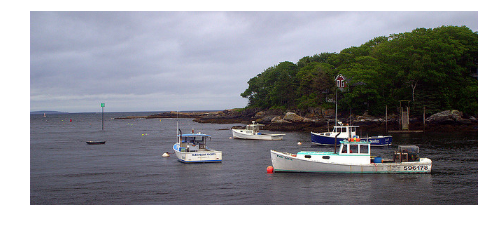

In [20]:
img_id = [imgIds[np.random.randint(0,len(imgIds))]]

preprocessed_images = build_image_features(img_id, coco, 
                         target_size, output_shape,
                         preprocess_input,
                         img_list_file, dataset_directory,
                         [])

preprocessed_images = np.asarray(preprocessed_images)
img_features = img_model.predict(preprocessed_images)
# img_features = np.asarray([img_features])
img = coco.loadImgs(img_id)[0]

text_in = np.zeros((1,gen.max_token_len))
text_in[0][:] = np.full((gen.max_token_len,), 0)
text_in[0][0] = gen.token_to_id['<start>']

predictions = []
for arg in range(gen.max_token_len-1):
    pred = model.predict([img_features, text_in])
    tok = np.argmax(pred[0][arg])
    word = gen.id_to_token[tok]
    text_in[0][arg+1] = tok
    if word == '<end>':
        break
    predictions.append(word)

print ' '.join(predictions) + '.'
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [ ]:
# For generating test results in bulk

from IPython.display import Image
import time
import string
import pickle
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import progressbar
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# Variables to set / change
dataset_directory = '/scratch/jyotish/show_and_tell_coco/data/COCO/extracted'
token_file_name = 'val2014'

# initialize COCO api for caption annotations
annFile = '{}/annotations/captions_{}.json'.format(dataset_directory, token_file_name)
coco_caps = COCO(annFile)

# Load all captions
annotation_ids = coco_caps.getAnnIds();
annotations = coco_caps.loadAnns(annotation_ids)

class Caption:
    def __init__(self, name):
        self.name = name
        self.captions = []
        self.result = ''
        
    def add(self, caption):
        self.captions.append(caption)
        
test_results = {}

for annotation in annotations[:200]:
    caption = annotation['caption']
    img_name = annotation['image_id']
    caption = str(caption).translate(None, string.punctuation).lower()
    
    try:
        cap_obj = test_results[str(img_name)]
        cap_obj.add(caption)
    except Exception as e:
#         print str(e)
        feature_dataset = h5py.File('/scratch/jyotish/show_and_tell_coco/data/COCO/preprocessed/test_features.h5', 'r')
        img_features = feature_dataset[str(img_name)]['cnn_features'][:]

        # image_filenames = get_image_filenames(dataset_directory + '/' + img_list_file)

        # print img_features.shape
        features = np.array([img_features])

        text_in = np.zeros((1,gen.max_token_len))
        text_in[0][:] = np.full((gen.max_token_len,), 0)
        text_in[0][0] = 4230

        # print features,text_in
        arr = []
        zeros = np.array([np.zeros(512)])
        for arg in range(gen.max_token_len-1):
            pred = model.predict([features, zeros, text_in])
            tok = np.argmax(pred[0][arg])
            word = gen.id_to_token[tok]
            text_in[0][arg+1] = tok
            if word == '<end>':
                break
            arr.append(word)

        arr.append('.')
        cap_obj = Caption(img_name)
        cap_obj.add(caption)
        cap_obj.result = ' '.join(arr)
        test_results.update({img_name: cap_obj})
#         print cap_obj.result
        
import pickle
pickle.dump(test_results, open('/scratch/jyotish/show_and_tell_coco/data/COCO/preprocessed/test_results.p', 'wb') )

In [ ]:
# Sample code for importing tested results
import pickle

class Caption:
    def __init__(self, name):
        self.name = name
        self.captions = ['','','','','']
        self.result = ''
        
    def add(self, caption_number, caption):
        self.captions[caption_number] = caption
        
test_results = pickle.load(open('../data/flicker8k/preprocessed/test_results.p', 'rb'))

for img_name in test_results:
    ground_truth = test_results[img_name].captions
    result = test_results[img_name].result